In [ ]:
import ipywidgets
ipywidgets.__version__

import pandas as pd
import geopandas as gpd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import shap

In [ ]:
file_path='F:/내 드라이브/02. 논문연구/12. 통행유발원단위 분석/분석공간/'

In [ ]:
data1=gpd.read_file('F:/내 드라이브/02. 논문연구/12. 통행유발원단위 분석/데이터 정제_확인/공간분석용데이터_연면적_재산정_더미추가.gpkg')

In [ ]:
data1.columns

Index(['GRID_ID', '총_통행량_모든_이동수단', '총_통행량_도보_기타_제외', '총_통행량_지하철_철도',
       '총_통행량_차량', '총_통행량_도보_기타', '총_통행량_시내_시외_버스', '총_유입통행량_모든_이동수단',
       '총_유출통행량_모든_이동수단', '총_유입통행량_도보_기타_제외', '총_유출통행량_도보_기타_제외',
       '총_유입통행량_지하철_철도', '총_유출통행량_지하철_철도', '총_유입통행량_차량_x', '총_유출통행량_차량_x',
       '총_유입통행량_도보_기타', '총_유출통행량_도보_기타', '총_유입통행량_시내_시외_버스',
       '총_유출통행량_시내_시외_버스', '데이터유무', 'overlap_ar', 'hex_area', 'overlap_ra',
       '주거시설', '업무시설', '상업시설', '공공문화시설', '산업시설', '운수시설', '기타시설',
       'nearest_station_id', 'nearest_station_name', 'nearest_line',
       'nearest_dist_m', '섬_여부', '지하철근접', 'geometry'],
      dtype='object')

In [ ]:
data1=data1.rename(columns={'총_유입통행량_차량_x':'총_유입통행량_차량','총_유출통행량_차량_x':'총_유출통행량_차량'})

In [ ]:
# ② 총통행량 및 세부 항목 생성
data1["총통행량"] = (
    data1["총_유입통행량_모든_이동수단"].fillna(0)
    + data1["총_유출통행량_모든_이동수단"].fillna(0)
)

data1["총통행량_도보기타제외"] = (
    data1["총_유입통행량_도보_기타_제외"].fillna(0)
    + data1["총_유출통행량_도보_기타_제외"].fillna(0)
)

data1["총통행량_도보기타"] = (
    data1["총_유입통행량_도보_기타"].fillna(0)
    + data1["총_유출통행량_도보_기타"].fillna(0)
)

data1["총통행량_버스"] = (
    data1["총_유입통행량_시내_시외_버스"].fillna(0)
    + data1["총_유출통행량_시내_시외_버스"].fillna(0)
)

data1["총통행량_철도"] = (
    data1["총_유입통행량_지하철_철도"].fillna(0)
    + data1["총_유출통행량_지하철_철도"].fillna(0)
)

data1["총통행량_차량"] = (
    data1["총_유입통행량_차량"].fillna(0)
    + data1["총_유출통행량_차량"].fillna(0)
)

# ③ urban 더미
data1["urban_dummy"] = 0
data1.loc[data1['overlap_ra']>=0.15,"urban_dummy"]=1

# ④ 로그 변환
data1["ln_총통행량"] = np.log1p(data1["총통행량"])

# ⑤ 업무상업시설 연면적 결합
data1["업무상업시설"] = (
    data1["상업시설"].fillna(0)
    + data1["업무시설"].fillna(0)
)

data1["주거시설"] = data1["주거시설"].fillna(0)
data1["공공문화시설"] = data1["공공문화시설"].fillna(0)
data1["산업시설"] = data1["산업시설"].fillna(0)
data1["운수시설"] = data1["운수시설"].fillna(0)
data1["기타시설"] = data1["기타시설"].fillna(0)


# ⑦ 천㎡ 단위 변수 생성
for col in ["주거시설", "업무상업시설", "공공문화시설", "산업시설", "운수시설", "기타시설"]:
    data1[col.replace("연면적", "천m2")] = data1[col] / 1000


data1=data1.loc[data1['섬_여부']==0]

In [ ]:
data1['ln_주거시설']=np.log1p(data1['주거시설'])
data1['ln_업무상업시설']=np.log1p(data1['업무상업시설'])
data1['ln_공공문화시설']=np.log1p(data1['공공문화시설'])
data1['ln_산업시설']=np.log1p(data1['산업시설'])
data1['ln_운수시설']=np.log1p(data1['운수시설'])
data1['ln_기타시설']=np.log1p(data1['기타시설'])

In [ ]:
data1["ln_총_통행량_도보_기타_제외"] = np.log1p(data1["총_통행량_도보_기타_제외"])

In [ ]:
data2=data1.loc[~data1["ln_총_통행량_도보_기타_제외"].isnull()]

In [ ]:
len(data1)

18629

# XGBOOST 분석

In [ ]:
# 2️⃣ 변수 선택
features = [
    '주거시설', '업무상업시설', '공공문화시설',
    '산업시설', '운수시설', '기타시설', 'urban_dummy','nearest_dist_m']

features = [
    'ln_주거시설', 'ln_업무상업시설', 'ln_공공문화시설',
    'ln_산업시설', 'ln_운수시설', 'ln_기타시설', 'urban_dummy','nearest_dist_m']
#target = 'ln_총통행량'
target = 'ln_총_통행량_도보_기타_제외'

X = data2[features]
y = data2[target]

# 3️⃣ train / test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 4️⃣ XGBoost 회귀모형
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 손실함수: 제곱오차 최소화
    n_estimators=200,              # 트리 500개 (ensemble)
    learning_rate=0.05,            # 학습률 (낮을수록 안정, 느림)
    max_depth=6,                   # 개별 트리의 깊이 (복잡도)
    subsample=0.8,                 # 각 트리 학습 시 샘플 80%만 사용 (과적합 방지)
    colsample_bytree=0.8,          # 변수 80%만 사용 (랜덤성 부여)
    random_state=42                # 재현성을 위한 seed
)

model.fit(X_train, y_train)

# 5️⃣ 예측 및 성능평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")

R²: 0.679, RMSE: 1.094


C:\Users\jesng\.conda\envs\geo_env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# 2️⃣ 변수 선택
features = [
    '주거시설', '업무상업시설', '공공문화시설',
    '산업시설', '운수시설', '기타시설', 'urban_dummy','nearest_dist_m']

#features = [
#    'ln_주거시설', 'ln_업무상업시설', 'ln_공공문화시설',
#    'ln_산업시설', 'ln_운수시설', 'ln_기타시설', 'urban_dummy','nearest_dist_m']
#target = 'ln_총통행량'
target = '총_통행량_도보_기타_제외'

X = data2[features]
y = data2[target]

# 3️⃣ train / test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
####하이퍼 파라미터 튜닝하기

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, cv=3, scoring='r2')
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)


{'subsample': 0.8, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}
0.6735755862398533


In [ ]:
# 4️⃣ XGBoost 회귀모형
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 손실함수: 제곱오차 최소화
    n_estimators=800,              # 트리 500개 (ensemble)
    learning_rate=0.01,            # 학습률 (낮을수록 안정, 느림)
    max_depth=6,                   # 개별 트리의 깊이 (복잡도)
    subsample=0.8,                 # 각 트리 학습 시 샘플 80%만 사용 (과적합 방지)
    colsample_bytree=1,          # 변수 80%만 사용 (랜덤성 부여)
    random_state=42                # 재현성을 위한 seed
)

model.fit(X_train, y_train)

# 5️⃣ 예측 및 성능평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")

R²: 0.670, RMSE: 1.147


C:\Users\jesng\.conda\envs\geo_env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 윈도우 폰트 경로 설정 (맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 음수기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


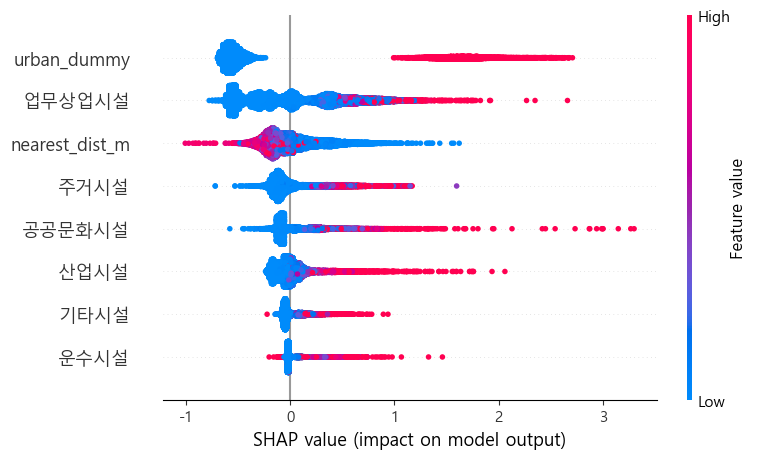

In [ ]:
# 6️⃣ SHAP 해석 (직접/간접효과 대용)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

# 전체 변수 중요도
shap.summary_plot(shap_values, X)

1) 전역(Global) 중요도 표 + 방향성 요약

무엇: 변수별 평균 |SHAP|(전역 영향력), 평균 SHAP 부호(방향성), 주요 분위수(Q10/50/90).

왜: 독자가 변수 영향의 “크기와 일관된 방향”을 표로 즉시 파악.

In [ ]:
import numpy as np
import pandas as pd
import shap

sv = shap_values.values if hasattr(shap_values, "values") else shap_values # (n, p)
cols = list(X.columns)
df_imp = pd.DataFrame({
    "feature": cols,
    "mean_abs_shap": np.mean(np.abs(sv), axis=0),
    "mean_shap": sv.mean(axis=0),
    "q10": np.quantile(sv, 0.10, axis=0),
    "q50": np.quantile(sv, 0.50, axis=0),
    "q90": np.quantile(sv, 0.90, axis=0),
})
df_imp = df_imp.sort_values("mean_abs_shap", ascending=False)
df_imp


,feature,mean_abs_shap,mean_shap,q10,q50,q90
6,urban_dummy,0.784535,-0.090611,-0.635567,-0.535547,1.661163
1,업무상업시설,0.398640,0.018890,-0.551839,-0.043125,0.689273
7,nearest_dist_m,0.202043,0.006888,-0.257003,-0.052292,0.390855
0,주거시설,0.170973,0.006456,-0.173865,-0.086669,0.385589
2,공공문화시설,0.147085,0.020261,-0.111307,-0.081625,0.290449
3,산업시설,0.118211,0.013195,-0.164171,-0.019972,0.197426
5,기타시설,0.074098,0.007125,-0.066448,-0.038191,0.152065
4,운수시설,0.041606,0.010648,-0.026084,-0.016802,0.099961


2) 의사-탄력성/효과크기 해석(단위 연결)

무엇: 특성 1 표준편차(또는 IQR) 변화 시 예측값 변화량을 SHAP 합으로 근사.

왜: “천㎡ 증가 시 얼마만큼”처럼 정책 단위로 번역.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
Xz = pd.DataFrame(scaler.transform(X), columns=X.columns)

effect_per_sd = (np.abs(sv).mean(axis=0) / Xz.std(axis=0))  # 간단 대용치
pd.Series(effect_per_sd, index=cols).sort_values(ascending=False)


urban_dummy       0.784514
업무상업시설            0.398629
nearest_dist_m    0.202038
주거시설              0.170969
공공문화시설            0.147081
산업시설              0.118207
기타시설              0.074096
운수시설              0.041605
dtype: float64

3) 의사-직접/간접 기여 분해(상호작용 기반)
   
무엇: SHAP interaction values로 “개별 변수의 고유 기여(대각)”와 “쌍대 상호작용(비대각)”을 구분.

왜: 너가 말한 “직접/간접효과 대용”에 가장 근접한 비인과적 분해.

In [ ]:
# TreeExplainer에서 interaction_values 지원 (트리 계열)
sv_inter = shap.TreeExplainer(model).shap_interaction_values(X)  # (n, p, p)
# 변수 i의 '직접' 대용치: 대각 성분 평균
direct_proxy = sv_inter.diagonal(axis1=1, axis2=2).mean(axis=0)  # (p,)
# 변수 i의 '간접(상호작용)' 대용치: 행/열 합 - 대각
indirect_proxy = (np.sum(np.abs(sv_inter), axis=(0,1)) - np.abs(direct_proxy))  # 단순 예시
pd.DataFrame({"feature": cols, "direct_proxy": direct_proxy, "indirect_proxy": indirect_proxy})


,feature,direct_proxy,indirect_proxy
0,주거시설,0.032144,7069.126465
1,업무상업시설,0.058085,14010.041992
2,공공문화시설,0.054600,5980.512695
3,산업시설,0.030987,4457.940430
4,운수시설,0.026650,1768.221680
5,기타시설,0.017054,2889.862061
6,urban_dummy,-0.013989,25780.419922
7,nearest_dist_m,0.028417,7942.852539


변수별 영향 확인

In [ ]:
# === 전 변수 SHAP dependence plot 일괄 생성 ===
import os, re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import shap

# 1) 설정
features = [
    '주거시설_연면적', '업무상업시설_연면적', '공공문화시설_연면적',
    '산업시설_연면적', '운수시설_연면적', '기타시설_연면적', 'urban_dummy'
]
color_feat = 'urban_dummy'  # 컬러링(상호작용) 기준 변수
outdir = file_path+"shap_dependence_plots"
os.makedirs(outdir, exist_ok=True)
pdf_path = os.path.join(outdir, "shap_dependence_all.pdf")

# 2) SHAP 값 객체 호환(구버전/신버전)
# - 구버전: shap_values.values (np.array)
# - 신버전(Explanation): 그대로 넘겨도 OK
_sv = getattr(shap_values, "values", shap_values)

# 3) 재현가능한 점 분포(지터) 위해 seed (선택)
np.random.seed(42)

# 4) PNG 개별 저장 + PDF 묶기
with PdfPages(pdf_path) as pdf:
    for feat in features:
        # 자기 자신을 interaction으로 쓰면 컬러가 의미 없어질 수 있어 'auto'로 둠
        inter = color_feat if feat != color_feat else 'auto'

        plt.figure(figsize=(5.2, 4.2))
        shap.dependence_plot(
            feat,
            _sv,
            X,                       # pandas DataFrame 권장(컬럼명 인식)
            interaction_index=inter, # urban_dummy로 컬러링
            show=False,              # 바로 표시하지 않고 저장만
            alpha=0.8,               # 겹침 줄이기
            dot_size=12              # 점 크기
        )
        plt.title(f"SHAP Dependence: {feat} (color: {inter})")
        plt.tight_layout()

        # 파일명 안전화
        safe = re.sub(r"[^\w\-]+", "_", feat)
        png_path = os.path.join(outdir, f"shap_dependence_{safe}.png")
        plt.savefig(png_path, dpi=200)
        pdf.savefig()  # PDF에 현재 페이지 추가
        plt.close()

print(f"[완료] PNG: {outdir}/shap_dependence_*.png")
print(f"[완료] PDF : {pdf_path}")


[완료] PNG: F:/내 드라이브/02. 논문연구/12. 통행유발원단위 분석/분석공간/shap_dependence_plots/shap_dependence_*.png
[완료] PDF : F:/내 드라이브/02. 논문연구/12. 통행유발원단위 분석/분석공간/shap_dependence_plots\shap_dependence_all.pdf


<Figure size 520x420 with 0 Axes>

<Figure size 520x420 with 0 Axes>

<Figure size 520x420 with 0 Axes>

<Figure size 520x420 with 0 Axes>

<Figure size 520x420 with 0 Axes>

<Figure size 520x420 with 0 Axes>

<Figure size 520x420 with 0 Axes>

In [ ]:
# ---------------------------------------------------
# ① 기준선 입력값 (X_mean)
# ---------------------------------------------------
baseline = data1[[
    '주거시설_연면적', '업무상업시설_연면적', '공공문화시설_연면적',
    '산업시설_연면적', '운수시설_연면적', '기타시설_연면적', 'urban_dummy'
]].mean().to_frame().T  # (1행 데이터프레임)

# ---------------------------------------------------
# ② baseline 예측값 (로그 스케일 → exp 변환)
# ---------------------------------------------------
y_base_pred = model.predict(baseline)[0]
y_base = np.exp(y_base_pred) - 1  # Duan-smearing 비슷하게 로그 복원
print(f"기준선 예측 통행량(건/일): {y_base:.2f}")

# ---------------------------------------------------
# ③ 시나리오 목록 정의 (천㎡ 단위)
# ---------------------------------------------------
scenarios = {
    '주거시설_연면적': [10e3, 30e3, 50e3, 100e3, 200e3, 300e3],
    '업무상업시설_연면적': [3e3, 5e3, 10e3, 30e3, 50e3],
    '공공문화시설_연면적': [1e3, 3e3, 5e3, 10e3, 30e3],
    '산업시설_연면적': [5e3, 10e3, 20e3, 40e3],
    '운수시설_연면적': [0.5e3, 1e3, 1.5e3, 2e3],
    '기타시설_연면적': [0.1e3, 0.2e3, 0.3e3, 0.4e3]
}

# ---------------------------------------------------
# ④ 시나리오별 예측 및 변화량 계산 함수
# ---------------------------------------------------
def predict_scenario(var, increments):
    results = []
    for s in increments:
        X_s = baseline.copy()
        X_s[var] = baseline[var] + s  # 시나리오 적용
        y_s_pred = model.predict(X_s)[0]
        y_s = np.exp(y_s_pred) - 1     # 로그 역변환
        delta = y_s - y_base
        results.append({
            '변수': var.replace('_연면적', ''),
            '시나리오_천m2': s / 1000,
            '예상통행량_건일': y_s,
            '증가통행량_건일': delta,
            'm2당_증가통행량': delta / s,
            '천m2당_증가통행량': delta / (s / 1000)
        })
    return pd.DataFrame(results)

# ---------------------------------------------------
# ⑤ 모든 변수 시나리오 계산
# ---------------------------------------------------
all_results = pd.concat([
    predict_scenario(v, s) for v, s in scenarios.items()
], ignore_index=True)

# 엑셀로 저장
all_results.to_excel(file_path+"XGBoost_시나리오별_예상통행량.xlsx", index=False)

기준선 예측 통행량(건/일): 2238.74


In [ ]:
# ---------------------------------------------------
# ⑥ 결과 확인
# ---------------------------------------------------
pd.set_option('display.float_format', '{:.2f}'.format)

all_results

,변수,시나리오_천m2,예상통행량_건일,증가통행량_건일,m2당_증가통행량,천m2당_증가통행량
0,주거시설,10.00,2356.80,118.06,0.01,11.81
1,주거시설,30.00,2449.74,211.00,0.01,7.03
2,주거시설,50.00,2669.30,430.56,0.01,8.61
3,주거시설,100.00,4358.60,2119.86,0.02,21.20
4,주거시설,200.00,5810.42,3571.68,0.02,17.86
5,주거시설,300.00,6293.46,4054.72,0.01,13.52
6,업무상업시설,3.00,2296.24,57.50,0.02,19.17
7,업무상업시설,5.00,2171.74,-67.00,-0.01,-13.40
8,업무상업시설,10.00,2135.39,-103.35,-0.01,-10.33
9,업무상업시설,30.00,5535.00,3296.26,0.11,109.88


In [ ]:
import numpy as np
import pandas as pd

# ---------------------------------------------------
# ① 기준선 입력값 (X_mean)
# ---------------------------------------------------
baseline = data1[[
    '주거시설_연면적', '업무상업시설_연면적', '공공문화시설_연면적',
    '산업시설_연면적', '운수시설_연면적', '기타시설_연면적', 'urban_dummy'
]].mean().to_frame().T

# 도시형 / 비도시형 시나리오 구분 (선택 가능)
urban_scenarios = [0, 1]   # 0=비도시, 1=도시

# ---------------------------------------------------
# ② 시나리오 목록 정의 (천㎡ 단위)
# ---------------------------------------------------
scenarios = {
    '주거시설_연면적': [10e3, 30e3, 50e3, 100e3, 200e3, 300e3],
    '업무상업시설_연면적': [3e3, 5e3, 10e3, 30e3, 50e3],
    '공공문화시설_연면적': [1e3, 3e3, 5e3, 10e3, 30e3],
    '산업시설_연면적': [5e3, 10e3, 20e3, 40e3],
    '운수시설_연면적': [0.5e3, 1e3, 1.5e3, 2e3],
    '기타시설_연면적': [0.1e3, 0.2e3, 0.3e3, 0.4e3]
}

# ---------------------------------------------------
# ③ 시나리오별 예측 함수
# ---------------------------------------------------
def predict_scenario(var, increments, urban_dummy_val, baseline_mode="mean"):
    results = []

    # baseline 설정 (평균 or 0)
    if baseline_mode == "zero":
        X_base = baseline.copy()
        X_base[var] = 0
    else:
        X_base = baseline.copy()

    X_base["urban_dummy"] = urban_dummy_val

    # baseline 예측
    y_base_pred = model.predict(X_base)[0]
    y_base = np.exp(y_base_pred) - 1  # 로그 복원

    for s in increments:
        X_s = X_base.copy()
        X_s[var] = X_base[var] + s  # 시나리오 면적 적용
        y_s_pred = model.predict(X_s)[0]
        y_s = np.exp(y_s_pred) - 1
        delta = y_s - y_base

        results.append({
            'baseline_mode': baseline_mode,
            'urban_dummy': urban_dummy_val,
            '변수': var.replace('_연면적', ''),
            '시나리오_천m2': s / 1000,
            '예상통행량_건일': y_s,
            '증가통행량_건일': delta,
            '천m2당_증가통행량': delta / (s / 1000),
            '증가율(%)': (delta / y_base) * 100
        })

    return pd.DataFrame(results)

# ---------------------------------------------------
# ④ 두 가지 baseline 모드(mean/zero) 병렬 계산
# ---------------------------------------------------
all_results = pd.concat([
    predict_scenario(v, s, urban_dummy_val, baseline_mode)
    for baseline_mode in ["mean", "zero"]
    for urban_dummy_val in urban_scenarios
    for v, s in scenarios.items()
], ignore_index=True)

# ---------------------------------------------------
# ⑤ 결과 저장
# ---------------------------------------------------
all_results.to_excel(file_path+"XGBoost_시나리오별_도시비도시_유형별.xlsx", index=False)

print("✅ XGBoost 기반 시나리오별 예측 완료 (baseline: mean & zero / 도시·비도시 구분 포함)")
display(all_results.head(10))


✅ XGBoost 기반 시나리오별 예측 완료 (baseline: mean & zero / 도시·비도시 구분 포함)


,baseline_mode,urban_dummy,변수,시나리오_천m2,예상통행량_건일,증가통행량_건일,천m2당_증가통행량,증가율(%)
0,mean,0,주거시설,10.00,2356.80,118.06,11.81,5.27
1,mean,0,주거시설,30.00,2449.74,211.00,7.03,9.42
2,mean,0,주거시설,50.00,2669.30,430.56,8.61,19.23
3,mean,0,주거시설,100.00,4358.60,2119.86,21.20,94.69
4,mean,0,주거시설,200.00,5810.42,3571.68,17.86,159.54
5,mean,0,주거시설,300.00,6293.46,4054.72,13.52,181.12
6,mean,0,업무상업시설,3.00,2296.24,57.50,19.17,2.57
7,mean,0,업무상업시설,5.00,2171.74,-67.00,-13.40,-2.99
8,mean,0,업무상업시설,10.00,2135.39,-103.35,-10.33,-4.62
9,mean,0,업무상업시설,30.00,5535.00,3296.26,109.88,147.24


In [ ]:
##### 상호작용 테스트
# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_inter = explainer.shap_interaction_values(X_train)

# 평균 절대값으로 상호작용 강도 계산
cols = X_train.columns
interaction_matrix = pd.DataFrame(
    np.abs(shap_inter).mean(axis=0),
    index=cols, columns=cols
)

# 상호작용 상위 10개
top_pairs = (
    interaction_matrix.where(np.triu(np.ones(interaction_matrix.shape), 1).astype(bool))
    .stack()
    .sort_values(ascending=False)
    .head(10)
)
print("🔸 상호작용 효과 Top 10")
print(top_pairs)


🔸 상호작용 효과 Top 10
주거시설_연면적    업무상업시설_연면적    0.14
            urban_dummy   0.06
            공공문화시설_연면적    0.05
업무상업시설_연면적  산업시설_연면적      0.05
            urban_dummy   0.03
            공공문화시설_연면적    0.03
공공문화시설_연면적  urban_dummy   0.02
주거시설_연면적    산업시설_연면적      0.02
업무상업시설_연면적  운수시설_연면적      0.02
산업시설_연면적    urban_dummy   0.02
dtype: float32


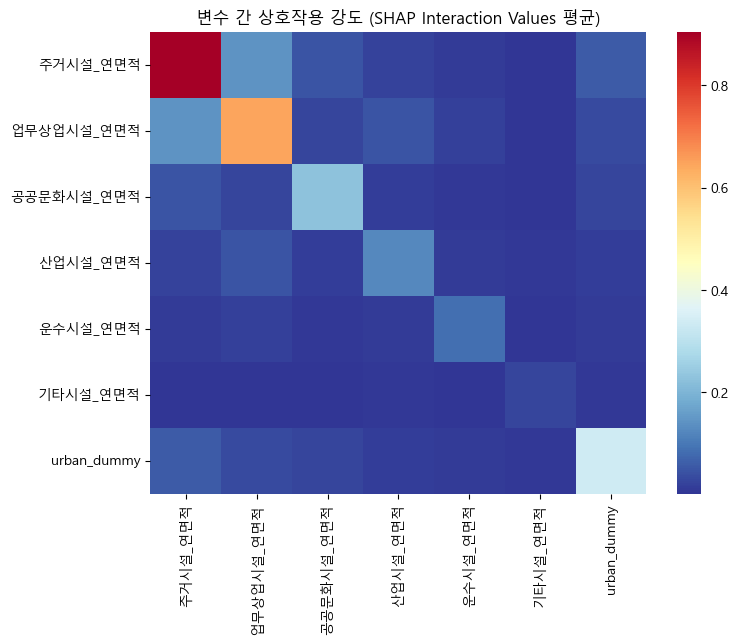

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(interaction_matrix, cmap="RdYlBu_r", annot=False)
plt.title("변수 간 상호작용 강도 (SHAP Interaction Values 평균)")
plt.show()


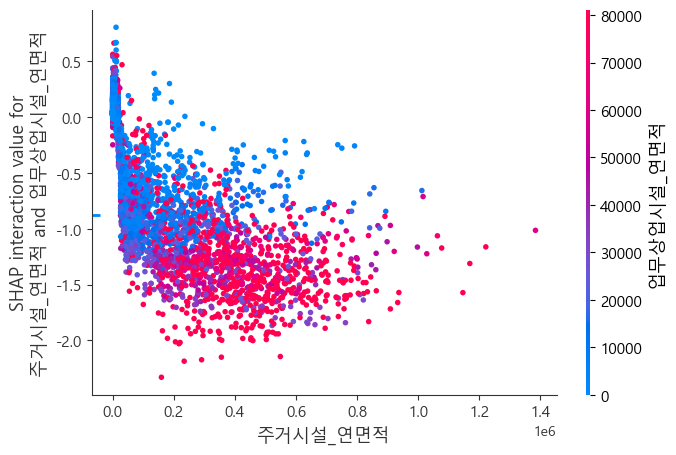

In [ ]:
shap.dependence_plot(
    ("주거시설_연면적", "업무상업시설_연면적"),
    shap_inter, X_train, display_features=X_train
)


In [ ]:
# 복합 시나리오 정의
combo_scenarios = [
    {'name': '주거+상업', '주거시설_연면적': 100e3, '업무상업시설_연면적': 50e3},
    {'name': '주거+상업+공공', '주거시설_연면적': 200e3, '업무상업시설_연면적': 100e3, '공공문화시설_연면적': 30e3},
    {'name': '산업+운수', '산업시설_연면적': 50e3, '운수시설_연면적': 2e3},
    {'name': '전용종합개발', '주거시설_연면적': 200e3, '업무상업시설_연면적': 150e3,
     '공공문화시설_연면적': 50e3, '운수시설_연면적': 2e3}
]

results = []
for sc in combo_scenarios:
    X_s = baseline.copy()
    for var, inc in sc.items():
        if var in baseline.columns:
            X_s[var] = baseline[var] + inc
    y_s_pred = model.predict(X_s)[0]
    y_s = np.exp(y_s_pred) - 1
    dy = y_s - y_base
    results.append({
        '시나리오': sc['name'],
        '예상통행량_건일': y_s,
        '증가통행량_건일': dy,
        '증가율(%)': dy / y_base * 100
    })

df_combo = pd.DataFrame(results)
df_combo

,시나리오,예상통행량_건일,증가통행량_건일,증가율(%)
0,주거+상업,7494.42,5255.68,234.76
1,주거+상업+공공,11339.63,9100.89,406.52
2,산업+운수,2670.33,431.59,19.28
3,전용종합개발,15707.91,13469.17,601.64
